## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import tqdm
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from tqdm import tqdm
import numpy as np

from PIL import Image

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch
import matplotlib.pyplot as plt

#DERT model
from transformers import DetrForObjectDetection


In [2]:
print(os.getcwd())

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


Load model state


In [3]:
from transformers import DetrConfig, DetrForObjectDetection

config = DetrConfig.from_pretrained('facebook/detr-resnet-50',revision="no_timm",num_labels=2,id2label={0:"text",1:"fracture"},
                                                             ignore_mismatched_sizes=True) 
                                                             
model = DetrForObjectDetection(config)
best_model = torch.load(f'../models/DETR_Model.pt',map_location=torch.device('cpu'))
model.load_state_dict(best_model['model_state_dict'])
print(best_model['best_loss'])

0.8507886904489268


In [4]:

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [5]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

Load dataset

In [6]:
import sys
sys.path.append('../')
%cd ..
from src.data.my_rpg_dataset import CocoDetection
from src.data.my_rpg_dataset import collate_fn_COCO
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(path_folder="data", processor=processor,status='test')
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_COCO, batch_size=1, shuffle=False,num_workers=0)

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [12]:
evaluator = CocoEvaluator(coco_gt=train_dataset.coco, iou_types=["bbox"])

In [8]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [9]:
model.eval()

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [12]:
%cd master_thesis_dtu

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


In [13]:
#evaluator.coco_eval['bbox'].params.catIds = [1]

print("Running evaluation...")
for idx, batch in enumerate(tqdm(train_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
    # provide to metric
    # metric expects a list of dictionaries, each item 
    # containing image_id, category_id, bbox and score keys 
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)
    if idx == 3 : break

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/3041 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [14]:
results

[{'scores': tensor([0.9997]),
  'labels': tensor([0]),
  'boxes': tensor([[ 543.8913,  937.7892,  604.2091, 1013.7080]])}]

Try do it per class

In [25]:
evaluator.coco_eval['bbox'].params.catIds

[0]

In [26]:
coco_gt.getCatIds()

[0, 1]

## Model accuracy


In [16]:
score_threshold = 0.7
iou_threshold = 0.0

print('----------------------Model evaluation started--------------------------')

device = next(model.parameters()).device
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized
       
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        # turn into a list of dictionaries (one item for each example in the batch)
        orig_target_sizes = torch.stack([target["orig_size"] for target in targets], dim=0)
        results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
        # provide to metric
        # metric expects a list of dictionaries, each item 
        # containing image_id, category_id, bbox and score keys 
        predictions = {target['image_id'].item(): output for target, output in zip(targets, results)}
        predictions = prepare_for_coco_detection(predictions)

        outputs = predictions

        for i, output in enumerate(outputs):
            boxes = torch.FloatTensor([output['bbox']])
            scores = [output['score']]
            labels = [output['category_id']]
            target_boxes_norm = targets[0]['boxes'].cpu()
            target_labels = targets[0]['class_labels'].cpu().numpy()
            target_size = targets[0]['size'].cpu().numpy()
            total += target_labels.size

            for box, score, label in zip(boxes, scores, labels):
                if label in target_labels:
                    index = np.where(target_labels == label)[0][0]
                    target_box = target_boxes_norm[index]
                    
                    # convert normalized target box to original coordinates
                    target_box *= torch.FloatTensor([target_size[1], target_size[0], target_size[1], target_size[0]])
                    
                    if score > score_threshold and box_iou(box.unsqueeze(0), target_box.unsqueeze(0)) >= iou_threshold:
                        correct += 1
        if idx == 5 : break
    accuracy = 100 * correct / total

    print('----------------------train ended--------------------------')
    print('The total model accuracy in the test set was: ', accuracy)


----------------------Model evaluation started--------------------------


  0%|          | 0/3041 [00:00<?, ?it/s]

----------------------train ended--------------------------
The total model accuracy in the test set was:  34.04255319148936


In [22]:
from torchvision.ops import box_iou

print('----------------------Model evaluation started--------------------------')

device = next(model.parameters()).device
model.eval()
correct = 0
total = 0
score_threshold = 0.5
iou_threshold = 0.5

with torch.no_grad():
    for batch in tqdm(train_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        # post-process the output to get predicted boxes and labels
        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
        
        # calculate accuracy
        for i, (pred, target) in enumerate(zip(results, labels)):
            pred_boxes = pred['boxes']
            pred_scores = pred['scores']
            pred_labels = pred['labels']
            target_boxes = target['boxes']
            target_labels = target['class_labels']
            total += target_labels.size(0)
            for j in range(len(pred_labels)):
                if pred_scores[j] > score_threshold and pred_labels[j] in target_labels:
                    indices = (target_labels == pred_labels[j]).nonzero(as_tuple=True)[0]
                    for index in indices:
                        iou = box_iou(pred_boxes[j].unsqueeze(0), target_boxes[index].unsqueeze(0))
                        if iou > iou_threshold:
                            correct += 1
                            break



accuracy = 100 * correct / total

print('----------------------Evaluation ended--------------------------')
print('The total model accuracy in the test set was: ', accuracy)


----------------------Model evaluation started--------------------------


  0%|          | 0/3041 [00:00<?, ?it/s]

----------------------Evaluation ended--------------------------
The total model accuracy in the test set was:  0.0


In [17]:
labels

[{'size': tensor([1092,  800]),
  'image_id': tensor([1]),
  'class_labels': tensor([1, 0]),
  'boxes': tensor([[0.4034, 0.4596, 0.1517, 0.0572],
          [0.8851, 0.4966, 0.0644, 0.0623]]),
  'area': tensor([7586.8203, 3502.6497]),
  'iscrowd': tensor([0, 0]),
  'orig_size': tensor([1188,  870])}]

In [57]:
for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected text with confidence 0.996 at location [738.74, 559.0, 794.27, 631.82]
Detected fracture with confidence 0.959 at location [273.46, 483.92, 431.31, 569.57]


In [58]:
# get the first bounding box coordinates in the target
normalized_box = targets[0]['boxes'][0]

# get the original image size
orig_size = targets[0]['orig_size']

# convert the normalized bounding box to pixel coordinates
x, y, w, h = normalized_box.tolist()
top_left_x = int(x * orig_size[0])
top_left_y = int(y * orig_size[1])
bottom_right_x = int((x + w) * orig_size[0])
bottom_right_y = int((y + h) * orig_size[1])

# create a tuple with the pixel coordinates
box_coords = (top_left_x, top_left_y, bottom_right_x, bottom_right_y)

print(box_coords)

(479, 399, 659, 449)


In [61]:
targets[0]

{'size': tensor([1092,  800]),
 'image_id': tensor([1]),
 'class_labels': tensor([1, 0]),
 'boxes': tensor([[0.4034, 0.4596, 0.1517, 0.0572],
         [0.8851, 0.4966, 0.0644, 0.0623]]),
 'area': tensor([7586.8203, 3502.6497]),
 'iscrowd': tensor([0, 0]),
 'orig_size': tensor([1188,  870])}

#### Visualization

In [17]:
cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

In [18]:
id2label

{0: 'text', 1: 'fracture'}

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = train_dataset[3]

In [20]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 1333, 573])


In [21]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [22]:
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                
                                                                threshold=0.6)

In [23]:
postprocessed_outputs

[{'scores': tensor([0.9859, 0.9988, 0.8389, 0.9991]),
  'labels': tensor([1, 0, 0, 1]),
  'boxes': tensor([[0.3701, 0.3184, 0.4983, 0.3638],
          [0.0799, 0.8370, 0.1511, 0.8991],
          [0.1450, 0.7372, 0.1957, 0.7734],
          [0.4784, 0.3392, 0.6983, 0.4043]])}]

In [24]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [25]:
%cd notebooks

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


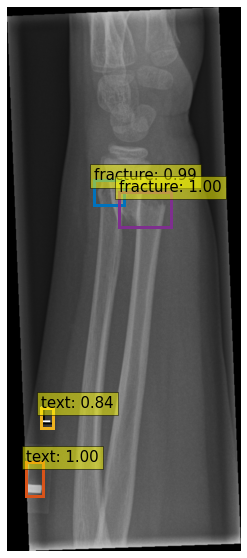

In [26]:
# load image based on ID
image_id = target['image_id'].item()
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image['file_name']))


# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.6)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

Target Image n°2


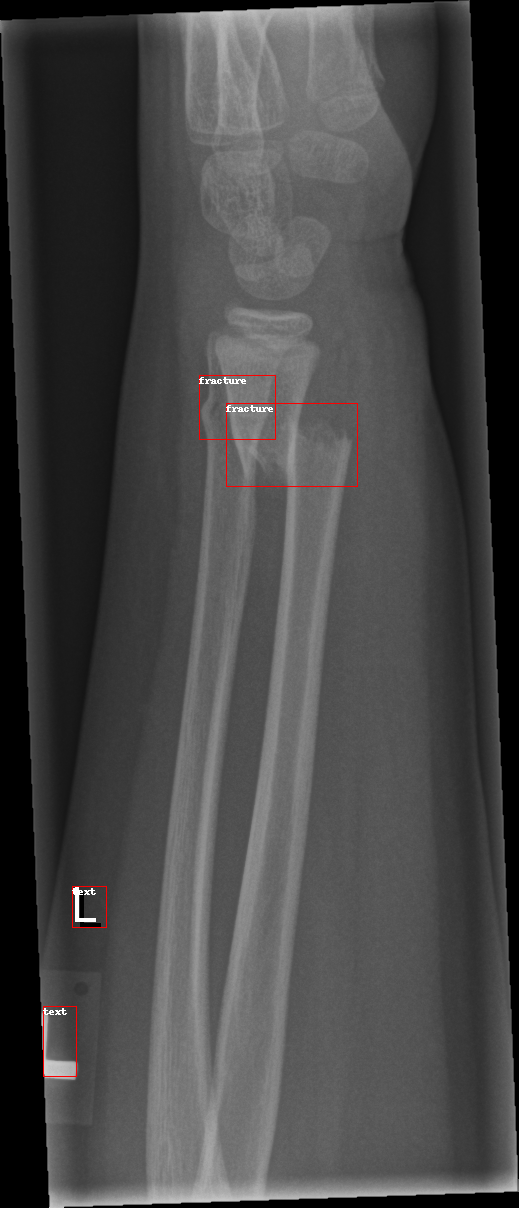

In [32]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
print('Target Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image)

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image